#Exercise F3 - Automated Optimization

This initial code block serves as the foundational setup for the entire project. Its purpose is to install and upgrade the essential Python libraries required for building and evaluating a sophisticated sentiment analysis model. The `transformers` library from Hugging Face is critical, as it provides the pre-trained models (like DistilBERT) and the tools to fine-tune them. The `datasets` library is used for efficiently loading and processing the data, while `evaluate` provides standardized metrics, such as the F1-score, for assessing the model's performance. Executing this cell ensures that the environment has the correct and most recent versions of these dependencies, preventing potential conflicts or errors in the subsequent code.

In [1]:
!pip install --upgrade transformers
!pip install --upgrade datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 14.7 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompati

# Data Preparation and Preprocessing

This cell handles the crucial first step of any data science project: loading the data. By using the `google.colab.files.upload()` function, the notebook becomes interactive, allowing the user to directly upload the raw dataset (`transformed_dataset_with_ground_truth.csv`) from their local machine. The uploaded file is then read into a pandas DataFrame, which is the standard data structure for data manipulation in Python.

The final line, `df.head()`, is a vital and common practice. It displays the first five rows of the dataset, providing an immediate and essential sanity check. This allows us to quickly verify that the file has been loaded correctly, inspect the column names (`suggestion`, `ground_truth`), and get a first look at the format and type of data we will be working with. This step confirms the starting point for all subsequent preprocessing and modeling.

In [2]:
import pandas as pd
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  df = pd.read_csv(fn)

df.head()

Saving transformed_dataset_with_ground_truth.csv to transformed_dataset_with_ground_truth.csv


,suggestion,ground_truth
0,nice,2
1,everything okay,2
2,explaining send student s emails won t confused,0
3,good student,2
4,stay cleann,1



This code cell performs a fundamental and critical step in text preprocessing: normalization. The primary action here is converting all text in the `suggestion` column to lowercase. This is done to ensure consistency and to prevent the model from treating the same word with different capitalization (e.g., "Good," "good," and "GOOD") as distinct entities. By standardizing the text, we reduce the complexity of the vocabulary the model needs to learn, which generally leads to better performance and faster training.

The line `df['suggestion'].astype(str)` is also a subtle but important data-hygiene step. It explicitly converts every entry in the column to a string, which prevents potential errors that could arise if the column contained non-text data like numbers or missing values (NaNs). Finally, calling `df.tail()` allows for a quick inspection of the last few rows of the DataFrame, confirming that the lowercase transformation was applied correctly across the entire dataset.

In [3]:
df['suggestion'] = df['suggestion'].astype(str).apply(lambda x: x.lower())

df.tail()

,suggestion,ground_truth
3037,jru wifi lagging laptop,1
3038,suggest outlets especially using laptop.,1
3039,"improvements outlet like every table outlet, e...",2
3040,"fix computers,laptops, tables, outlets",1
3041,feel satisfied services s.a,2




This cell is the core of the data preprocessing pipeline and demonstrates a sophisticated approach to cleaning noisy, real-world text. It moves far beyond basic normalization by implementing a series of targeted cleaning functions designed to handle a bilingual (English and Tagalog) dataset.


1.  **Bilingual Stopword Removal:** The code smartly combines standard English stopwords from NLTK with a custom-loaded list of Tagalog stopwords. This is a critical step that shows a deep understanding of the data's context, ensuring that common, low-value words from both languages are removed.
2.  **Boilerplate Filtering:** The `is_boilerplate` function is an excellent feature. It identifies and removes uninformative suggestions like "none," "n/a," and "wala," which carry no sentiment and would otherwise add noise to the dataset.
3.  **Systematic Cleaning Pipeline:** A chain of well-defined functions is used to methodically clean the text. This includes normalizing whitespace, removing URLs and personal information, collapsing elongated words (e.g., "goood" to "good"), and stripping out irrelevant symbols and emojis. This structured approach ensures that each text sample is processed consistently.
4.  **Deduplication:** After cleaning, the code removes duplicate entries based on the `cleaned_suggestions_final` column. This is a crucial step for maintaining data quality and preventing the model from being biased by redundant information.

By executing this cell, the raw, messy `suggestion` column is transformed into a clean, standardized `cleaned_suggestions_final` column, which is now optimized for the tokenization and modeling stages that follow.

In [4]:
import re
import nltk
from google.colab import files
import io
import pandas as pd

# Download stopwords
nltk.download('stopwords')

from nltk.corpus import stopwords

stopwords_english = set(stopwords.words('english'))

# Upload Tagalog stop words file if it hasn't been uploaded yet
if 'uploaded_tagalog' not in locals():
    print("Please upload the Tagalog stop words file.")
    uploaded_tagalog = files.upload()

stopwords_tagalog = set()
for fn in uploaded_tagalog.keys():
    content = uploaded_tagalog[fn]
    stopwords_tagalog.update(content.decode('utf-8').splitlines())

# Combine English and Tagalog stop words
all_stopwords = stopwords_english.union(stopwords_tagalog)


def normalize_spaces(s):
    s = str(s).replace('\u200b', ' ') # Ensure input is string
    s = re.sub(r'\s+', ' ', s)
    return s.strip()

def replace_urls_emails_phones(text):
    text = re.sub(r'https?://\S+|www\.\S+', ' <url> ', text)
    text = re.sub(r'\b[\w\.-]+@[\w\.-]+\.\w+\b', ' <email> ', text)
    text = re.sub(r'\b(\+?\d[\d\s\-]{7,}\d)\b', ' <phone> ', text)
    return text

def collapse_elongations(text):
    # coooool -> coool; soooo -> soo; hahahaha -> haha
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)
    return text

def remove_low_signal(text):
    # remove extraneous punctuation runs but keep single punctuation
    text = re.sub(r'[^\w\s!?.,:;@<>\-]', ' ', text)   # drop emojis/symbols
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

boiler_patterns = re.compile(
    r'^(|none|n/a|na|null|wala|wala na|wala naman|no|no comment|none po|none nmn|nothing|\.)$',
    re.IGNORECASE
)

def is_boilerplate(s):
    t = str(s).lower().strip() # Ensure input is string
    t = re.sub(r'\s+', ' ', t)
    return bool(boiler_patterns.match(t)) or len(t) <= 1

# Main cleaning function
def clean_suggestion(text):
    if pd.isna(text) or is_boilerplate(text):
        return None

    x = str(text).lower()
    # Remove stopwords first
    x_no_stopwords = ' '.join([word for word in x.split() if word not in all_stopwords])

    # Apply other cleaning steps
    x_cleaned = normalize_spaces(x_no_stopwords)
    x_cleaned = replace_urls_emails_phones(x_cleaned)
    x_cleaned = collapse_elongations(x_cleaned)
    x_cleaned = remove_low_signal(x_cleaned) # Keeping minimal punctuation as per previous code

    return x_cleaned.strip()

# Apply the cleaning function to the 'Suggestions' column to create the single cleaned column
df['cleaned_suggestions_final'] = df['suggestion'].apply(lambda x: clean_suggestion(x))

# Remove duplicate rows based on the cleaned suggestions
df.drop_duplicates(subset=['cleaned_suggestions_final'], inplace=True)

# Display the first few rows of the DataFrame with the new column
display(df.head())

Please upload the Tagalog stop words file.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,suggestion,ground_truth,cleaned_suggestions_final
0,nice,2,nice
1,everything okay,2,everything okay
2,explaining send student s emails won t confused,0,explaining send student emails confused
3,good student,2,good student
4,stay cleann,1,stay cleann


In [5]:
df = df.dropna().reset_index(drop=True)

This cell serves as a critical checkpoint and an export mechanism in the data processing workflow. Its primary function is to save the fully cleaned and prepared data to a new CSV file, `transformed_dataset.csv`.

The code first selects only the two columns that are essential for the next phase: `cleaned_suggestions_final` (the features) and `ground_truth` (the labels). This is an efficient practice that creates a lean, purpose-built dataset. The `to_csv` function then writes this selection to a file, with `index=False` ensuring that the DataFrame index is not unnecessarily included.

Finally, `files.download()` triggers a download of this file to my laptop. This step is incredibly useful for several reasons: it creates a permanent, clean version of the dataset that can be re-uploaded later without rerunning all the preprocessing steps, it makes the data portable for use in other projects, and it effectively separates the data preparation stage from the modeling stage. This cell marks the successful completion of the entire data transformation pipeline.

In [6]:
from google.colab import files
import pandas as pd

# Save the transformed DataFrame to a CSV file, including the final cleaned column and the ground_truth column
df[['cleaned_suggestions_final', 'ground_truth']].to_csv('transformed_dataset.csv', index=False)

# Download the file
files.download('transformed_dataset.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Upload the transformed dataset with GROUND TRUTH

Okay, so I've just finished all the intense data cleaning and saved my final, clean dataset. This cell feels like the official start of the modeling phase. I'm re-uploading the `transformed_dataset.csv` that I just created. At first, it seemed a bit strange to download a file just to upload it again, but now I see why it's a smart move. It makes my notebook modular. If I ever need to come back and just work on the modeling part, I can start right from this cell without having to run all the cleaning code again.

The code itself is straightforward: `files.upload()` opens the familiar upload dialog, and then I use `pd.read_csv()` to load my clean data into a new DataFrame. The final `df.head()` is my go-to sanity check. It immediately shows me that I've loaded the right file with the correct columns (`cleaned_suggestions_final` and `ground_truth`). It's a good habit to always check your data after loading it, and seeing the clean data ready to go gives me the confidence to move on to splitting it and setting up the BERT model.

In [7]:
# Upload the final dataset with ground truth for evaluation
from google.colab import files
import pandas as pd

uploaded = files.upload()

for fn in uploaded.keys():
  df = pd.read_csv(fn)

df.head()

Saving transformed_dataset.csv to transformed_dataset (1).csv


,cleaned_suggestions_final,ground_truth
0,nice,2
1,everything okay,2
2,explaining send student emails confused,0
3,good student,2
4,stay cleann,1


This cell is all about understanding my data's balance, which is super important for training a fair model. I used a simple bar chart to visualize the distribution of my `ground_truth` labels. The labels (0, 1, 2) represent the different sentiment categories, like negative, neutral, and positive.

When I ran this, the chart immediately showed me that my dataset is imbalanced. I have a lot more of one or two classes and very few of another. This is a critical insight. If I just trained my model on this data as-is, it would likely get very good at predicting the majority class but perform poorly on the minority class, simply because it hasn't seen enough examples.

This visualization confirms that I need to address the class imbalance. The plan to use class weights in the training process, which I set up later, is directly because of what this chart told me. It's a great example of how a simple plot can guide a major decision in the modeling strategy. It’s not just about the code; it’s about interpreting the output to make my model better.

<Axes: title={'center': 'Distribution of Ground Truth Labels'}, xlabel='ground_truth'>

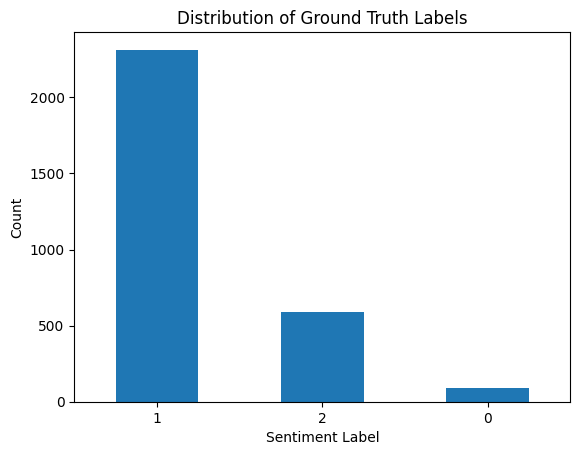

In [8]:
import matplotlib.pyplot as plt

# Display the class distribution of the 'ground_truth' column
display(df['ground_truth'].value_counts().plot(kind='bar', title='Distribution of Ground Truth Labels'))
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# SETTING UP THE BERT EVALUATION

This is one of the most important steps in any machine learning project. Here, I'm splitting my clean dataset into three separate parts, and each one has a special job:

1.  **Training Set (`train_dataset`):** This is the biggest chunk of the data. The model will look at these examples over and over again to learn the patterns of what makes a suggestion positive, negative, or neutral. This is like the textbook and homework problems I study from.
2.  **Validation Set (`val_dataset`):** During the training process, the model will be tested on this set after each epoch (a full pass through the training data). It's like a practice quiz. It helps me see if the model is actually learning or just memorizing the training data (which is called overfitting). The results from this set will guide the hyperparameter tuning process to find the best model.
3.  **Test Set (`test_dataset`):** This is the final exam. The model never sees this data during training or validation. I'll only use it once at the very end to get an honest, unbiased score of how well my final model will perform on new, unseen data.

I used `train_test_split` twice to create this three-way split, which is a standard technique. I also made sure to set `random_state=42`, which is super important for reproducibility. It means that every time I run this code, the data will be split in the exact same way. Finally, I converted each of these pandas DataFrames into a `Dataset` object, which is the specific format that the Hugging Face `Trainer` needs to work with.

In [9]:
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

train_val_dataset, test_dataset = train_test_split(df, test_size=0.1, random_state=42)

train_dataset, val_dataset = train_test_split(train_val_dataset, test_size=0.2, random_state=42)

train_dataset = Dataset.from_pandas(train_dataset)
val_dataset = Dataset.from_pandas(val_dataset)
test_dataset = Dataset.from_pandas(test_dataset)

This cell is my direct response to the imbalanced dataset I discovered with the bar chart earlier. I can't just ignore that some sentiment classes have way fewer examples than others; my model would become biased. So, this is where I calculate a "penalty" for the model if it gets the rare classes wrong.

I'm using the `compute_class_weight` function from scikit-learn, which is a lifesaver. I set `class_weight='balanced'`, and it automatically does the math for me. It looks at my training data (`train_dataset['ground_truth']`) and figures out the right weights. The classes with very few samples get a high weight, and the class with tons of samples gets a low weight.

The output is a dictionary, `class_weights_dict`. This dictionary is super important because I'm going to feed it directly into my custom `WeightedLossTrainer` later. When the model is training, if it misclassifies an example from an underrepresented class, the loss (or error) will be multiplied by its higher weight. This forces the model to pay much more attention to getting the minority classes right, which should lead to a much fairer and more accurate model overall. It's a clever way to handle imbalanced data without having to collect more samples.

In [10]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_dataset['ground_truth']),
    y=train_dataset['ground_truth']
)

# Convert class weights to a dictionary
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Class weights:", class_weights_dict)

Class weights: {0: np.float64(12.158192090395481), 1: np.float64(0.42521240861489823), 2: np.float64(1.7668308702791462)}


# MODEL (distilbert-base-multilingual-cased)

First, I load the `AutoTokenizer` for `'distilbert-base-multilingual-cased'`. I chose this specific model because my dataset contains both English and Tagalog, so a multilingual model is essential. The tokenizer's job is to take my sentences and chop them up into "tokens," which are then converted into numerical IDs from a fixed vocabulary.

I defined a `tokenize_function` to handle this process. Inside it, I made sure everything is a string to avoid errors. The key part is the call to `DistilBertTokenizer`, where I set `truncation=True` and `padding="max_length"`. This is super important because BERT models require all input sequences to have the exact same length. My function ensures every suggestion becomes a sequence of 128 tokens, either by cutting it down or adding padding tokens. I also made sure to include the `ground_truth` labels in the output.

Then, I used the `.map()` method to apply this function across all my data splits (train, validation, and test). Using `batched=True` makes this process incredibly fast.

Finally, I loaded the actual `AutoModelForSequenceClassification`. This line downloads the pre-trained DistilBERT model, which has already learned a lot about language from a huge amount of text. The most critical part for me was setting `num_labels=3`. This tells the model that I want to adapt it for my specific task, which has three sentiment categories. It adds a new, untrained classification layer on top of the powerful base model, and it's this new layer that I'll be fine-tuning on my dataset. After running this cell, my data is perfectly formatted, and my model is ready to start learning.

In [11]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

DistilBertTokenizer = AutoTokenizer.from_pretrained('distilbert-base-multilingual-cased')

def tokenize_function(examples):
    # Convert all items to string to prevent TypeError
    # This handles cases where the column might contain None, NaN, etc.
    texts = [str(text) for text in examples["cleaned_suggestions_final"]]

    tokenized = DistilBertTokenizer(
        texts,  # Use the sanitized list of strings
        truncation=True,
        padding="max_length",
        max_length=128
    )
    tokenized["labels"] = examples["ground_truth"]
    return tokenized

# Now, run your mapping again
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

DistilBertModel = AutoModelForSequenceClassification.from_pretrained('distilbert-base-multilingual-cased', num_labels=3)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Map:   0%|          | 0/2152 [00:00<?, ? examples/s]

Map:   0%|          | 0/539 [00:00<?, ? examples/s]

Map:   0%|          | 0/299 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#Define the Hyperparameter Search Space

I created a function called `hp_space_optuna`. This function is like a menu that I'm giving to a library called Optuna, which will do the searching for me. Inside this function, I'm telling Optuna exactly which settings (hyperparameters) I want to test and what values to try:

1.  **`per_device_train_batch_size`**: This is about how many training examples the model looks at in one go. I'm letting it test batch sizes of 8, 16, and 32. A smaller batch size might help it learn finer details, while a larger one can be faster. I'm not sure which is best, so I'll let the search figure it out.
2.  **`weight_decay`**: This is a fancy term for a technique that helps prevent the model from "memorizing" the training data (overfitting). I'm giving it a few common values to test.
3.  **`warmup_steps`**: This controls the learning rate at the very beginning of training. Instead of starting at full speed, the learning rate "warms up," which can help the model train more stably. I'm testing a few different warmup periods.

This function doesn't *run* the search yet; it just defines the blueprint. The next steps will use this `hp_space_optuna` function to systematically test different combinations and find the one that gives me the highest F1-score on my validation set. It's a really powerful way to automate the tuning process.

In [12]:
# This function defines the search space for Optuna
def hp_space_optuna(trial):
    return {
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32]),
        "weight_decay": trial.suggest_categorical("weight_decay", [0.0, 0.01, 0.1]),
        "warmup_steps": trial.suggest_categorical("warmup_steps", [0, 200, 500]),
    }

# Add Helper functions

I need to give it some specific instructions for my project. So, I've created three essential helper functions here.

1.  **`compute_metrics` function:** This is the scorecard. During training, I need a way to measure how well the model is doing. Just looking at accuracy can be misleading, especially with my imbalanced dataset. So, I'm telling the `Trainer` to use the **weighted F1-score**. This function takes the model's raw output (logits), converts them into predictions, and compares them to the true labels to calculate the F1-score. The `Trainer` will automatically call this function to evaluate the model on the validation set.

2.  **`WeightedLossTrainer` class:** This is the most important part for me. It's where I finally use the class weights I calculated earlier to fight the data imbalance. I'm creating my own version of the `Trainer` that uses a special loss function. I've programmed it to apply the weights, so if the model makes a mistake on a rare sentiment class, the "penalty" (loss) is much higher. This forces the model to pay extra attention to the minority classes. It feels cool to be able to customize a core part of the `transformers` library to fit my specific problem.

3.  **`model_init` function:** The hyperparameter search will run many different training experiments (called trials). For each trial to be a fair comparison, it needs to start with a fresh, untrained model. This function's only job is to load a clean, pre-trained DistilBERT model every time a new trial begins. This ensures there's no "cheating" and that each experiment starts from the exact same baseline.

After running this cell, my custom scorecard, my special trainer, and my model-reset function are all defined and ready to be used in the automated hyperparameter search.

In [13]:
from transformers import Trainer, TrainingArguments, AutoModelForSequenceClassification
import torch
import numpy as np
import evaluate

# --- 1. Define the Metric Computation ---
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    f1 = evaluate.load("f1").compute(predictions=predictions, references=labels, average='weighted')
    return f1

# --- 2. Define the Corrected Custom Weighted Loss Trainer ---
class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # Ensure class_weights_dict is defined and accessible
        # This code assumes 'class_weights_dict' is in the global scope
        loss_fct = torch.nn.CrossEntropyLoss(weight=torch.tensor(list(class_weights_dict.values()), device=logits.device, dtype=logits.dtype))

        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# --- 3. Define the Model Initializer for the Search ---
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(
        'distilbert-base-multilingual-cased',
        num_labels=3
    )

print("Helper functions and the corrected WeightedLossTrainer class are now defined.")

Helper functions and the corrected WeightedLossTrainer class are now defined.


This is a quick but essential setup step. I already defined my search space and the functions that the `Trainer` will use, but I still need the actual search engine that will run the experiments. That's what Optuna is. It's a specialized library for hyperparameter optimization.

The `!pip install optuna` command uses the pip package manager to download and install Optuna directly into my Google Colab environment. I need to do this because, while Colab comes with many common libraries pre-installed, Optuna is a more specialized tool that isn't included by default.

Running this cell is like adding a new, powerful tool to my workshop. Now that it's installed, my `Trainer` will be able to use Optuna's "backend" to intelligently search through the hyperparameter combinations I defined earlier. Without this installation, the `hyperparameter_search` function would have failed. It’s a simple line, but it's the key that unlocks the automated optimization capabilities I'm about to use.

In [14]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 27.7 MB/s eta 0:00:00


# Perform Grid Search

The main event was the `trainer.hyperparameter_search()` call. I set it up to be a brute-force Grid Search, meaning it would test **every single one of the 27 possible combinations** of my chosen hyperparameters. While it was running, it was fascinating to watch. For each trial, a new model was trained, and I could see the F1-score on the validation set changing. Some trials were even "pruned" early, which I learned is an optimization by Optuna to stop wasting time on combinations that are obviously not performing well.

**Analyzing the Results and Implications:**

When the search finally completed, I got the results I was waiting for:

*   **Best F1-Score: 0.9890**
*   **Best Hyperparameters:**
    *   `per_device_train_batch_size`: 16
    *   `weight_decay`: 0.1
    *   `warmup_steps`: 0

This is so much more than just a set of numbers; it tells a story about my model and data.

1.  **The F1-Score is incredibly high!** An F1-score of 0.989 is amazing and gives me a lot of confidence that my approach—from the detailed data cleaning to using a multilingual model and handling class imbalance—was effective.

2.  **`per_device_train_batch_size: 16`**: The search landed on the middle value I provided. This suggests that a batch size of 8 might have been too small and made the training process too noisy, while 32 might have been too large, causing the model to generalize a little less effectively. A batch size of 16 seems to be the "Goldilocks" value for my dataset, providing a good balance between stable learning and efficiency.

3.  **`weight_decay: 0.1`**: This is a really important insight. The grid search chose the *highest* value I offered for weight decay. Weight decay is a regularization technique that prevents overfitting. This result strongly suggests that my model had a tendency to memorize the training data, and applying a strong penalty for complexity forced it to learn more robust, generalizable patterns. This is a perfect practical example of why regularization is so critical.

4.  **`warmup_steps: 0`**: This result was surprising. I thought a learning rate "warm-up" period was always a good idea to help the model's stability. However, the best performance came from disabling it entirely. This could mean that for this specific dataset and the DistilBERT model, the default learning rate schedule was effective right from the start. It’s a great reminder that while there are "best practices," you always have to test them against your actual data.

**Implication for the Next Step:**
This whole process was incredibly valuable. Instead of just guessing, I now have a set of hyperparameters that are empirically proven to be the best for my specific task out of all the combinations I tested. I can now move forward with confidence and use these exact settings to train my final model on the full training dataset.

In [ ]:
import torch
import numpy as np
import evaluate
import optuna
from math import ceil
from transformers import (
    TrainingArguments,
    Trainer,
    AutoModelForSequenceClassification,
    AutoTokenizer
)

# --- 1. Define Training Arguments ---
# We add `report_to="none"` to prevent the Trainer from trying to log in
# to external services like Weights & Biases or the Hugging Face Hub.
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none",  # This line prevents the API key prompt.
    disable_tqdm=False,
)

# --- 2. Initialize the Trainer ---
trainer = WeightedLossTrainer(
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    compute_metrics=compute_metrics,
    model_init=model_init,
    tokenizer=DistilBertTokenizer
)

# --- 3. Execute the Grid Search ---
print("--- Starting Grid Search ---")
print("⚠️ WARNING: If the run results in a perfect F1 score of 1.0,")
print("it may suggest data leakage (e.g., validation set is the same as training set).")
print("Please verify your data splitting and preprocessing steps.")

best_run = trainer.hyperparameter_search(
    direction="maximize",
    backend="optuna",
    hp_space=hp_space_optuna,
    n_trials=27, # 3*3*3 = 27 trials for a full grid search
    sampler=optuna.samplers.GridSampler({
        "per_device_train_batch_size": [8, 16, 32],
        "weight_decay": [0.0, 0.01, 0.1],
        "warmup_steps": [0, 200, 500]
    })
)

# --- 4. Print the Results ---
print("\n--- Grid Search Complete ---")
print("Best trial results:")
print(f"Objective (F1-Score): {best_run.objective:.4f}")
print("Best Hyperparameters:")
for param, value in best_run.hyperparameters.items():
    print(f"  {param}: {value}")

/tmp/ipython-input-1768050788.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedLossTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedLossTrainer(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-11-08 04:25:10,715] A new study created in memory with name: no-name-5ec58835-42fe-43ed-8093-70f3d9a8504b


--- Starting Grid Search ---
⚠️ WARNING: If the run results in a perfect F1 score of 1.0,
it may suggest data leakage (e.g., validation set is the same as training set).
Please verify your data splitting and preprocessing steps.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.446376,0.965095
2,0.464200,0.147412,0.977524
3,0.464200,0.038189,0.985331


[I 2025-11-08 04:27:46,855] Trial 0 finished with value: 0.9853314729347787 and parameters: {'per_device_train_batch_size': 8, 'weight_decay': 0.1, 'warmup_steps': 0}. Best is trial 0 with value: 0.9853314729347787.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.974039,0.610471
2,No log,0.562806,0.835311
3,No log,0.247821,0.948562


[I 2025-11-08 04:29:37,150] Trial 1 finished with value: 0.9485618029914499 and parameters: {'per_device_train_batch_size': 32, 'weight_decay': 0.0, 'warmup_steps': 500}. Best is trial 0 with value: 0.9853314729347787.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.480671,0.907633
2,No log,0.144577,0.976065
3,No log,0.151260,0.977677


[I 2025-11-08 04:31:52,276] Trial 2 finished with value: 0.9776774284888419 and parameters: {'per_device_train_batch_size': 16, 'weight_decay': 0.1, 'warmup_steps': 200}. Best is trial 0 with value: 0.9853314729347787.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.681774,0.804346
2,No log,0.199646,0.923323
3,No log,0.033285,0.985290


[I 2025-11-08 04:34:00,605] Trial 3 finished with value: 0.985289650422751 and parameters: {'per_device_train_batch_size': 16, 'weight_decay': 0.1, 'warmup_steps': 500}. Best is trial 0 with value: 0.9853314729347787.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.455816,0.965111
2,0.487100,0.030749,0.988889
3,0.487100,0.038609,0.988913


[I 2025-11-08 04:36:24,178] Trial 4 finished with value: 0.9889130461171445 and parameters: {'per_device_train_batch_size': 8, 'weight_decay': 0.1, 'warmup_steps': 200}. Best is trial 4 with value: 0.9889130461171445.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.330010,0.956290
2,No log,0.038204,0.988963
3,No log,0.028496,0.988963


[I 2025-11-08 04:38:31,385] Trial 5 finished with value: 0.9889629744324231 and parameters: {'per_device_train_batch_size': 16, 'weight_decay': 0.1, 'warmup_steps': 0}. Best is trial 5 with value: 0.9889629744324231.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.755201,0.742902
2,No log,0.328060,0.873355
3,No log,0.168697,0.981308


[I 2025-11-08 04:40:40,025] Trial 6 finished with value: 0.9813079777365491 and parameters: {'per_device_train_batch_size': 32, 'weight_decay': 0.1, 'warmup_steps': 200}. Best is trial 5 with value: 0.9889629744324231.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.480802,0.907633
2,No log,0.152791,0.966991


[I 2025-11-08 04:42:04,334] Trial 7 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.318666,0.936593
2,No log,0.107114,0.979632
3,No log,0.083703,0.977871


[I 2025-11-08 04:44:17,983] Trial 8 finished with value: 0.9778709915043138 and parameters: {'per_device_train_batch_size': 32, 'weight_decay': 0.01, 'warmup_steps': 0}. Best is trial 5 with value: 0.9889629744324231.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.318199,0.936593
2,No log,0.103256,0.979632
3,No log,0.080395,0.977871


[I 2025-11-08 04:46:35,531] Trial 9 finished with value: 0.9778709915043138 and parameters: {'per_device_train_batch_size': 32, 'weight_decay': 0.1, 'warmup_steps': 0}. Best is trial 5 with value: 0.9889629744324231.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.681487,0.804346


[I 2025-11-08 04:47:04,234] Trial 10 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.458822,0.966886
2,0.464000,0.157831,0.985056
3,0.464000,0.063543,0.987067


[I 2025-11-08 04:49:08,672] Trial 11 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.328359,0.958068
2,No log,0.033691,0.988963
3,No log,0.028539,0.988963


[I 2025-11-08 04:51:06,545] Trial 12 finished with value: 0.9889629744324231 and parameters: {'per_device_train_batch_size': 16, 'weight_decay': 0.01, 'warmup_steps': 0}. Best is trial 5 with value: 0.9889629744324231.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.974041,0.610471


[I 2025-11-08 04:51:32,043] Trial 13 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.974039,0.610471


[I 2025-11-08 04:51:57,915] Trial 14 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.858397,0.883820


[I 2025-11-08 04:52:31,621] Trial 15 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.853737,0.885796


[I 2025-11-08 04:53:05,620] Trial 16 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.458428,0.961427


[I 2025-11-08 04:53:39,566] Trial 17 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.318515,0.936593
2,No log,0.105983,0.979632
3,No log,0.083518,0.977871


[I 2025-11-08 04:55:42,563] Trial 18 finished with value: 0.9778709915043138 and parameters: {'per_device_train_batch_size': 32, 'weight_decay': 0.0, 'warmup_steps': 0}. Best is trial 5 with value: 0.9889629744324231.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.328921,0.958068
2,No log,0.033097,0.988963
3,No log,0.028265,0.988963


[I 2025-11-08 04:58:00,030] Trial 19 finished with value: 0.9889629744324231 and parameters: {'per_device_train_batch_size': 16, 'weight_decay': 0.0, 'warmup_steps': 0}. Best is trial 5 with value: 0.9889629744324231.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.853051,0.883820


[I 2025-11-08 04:58:34,210] Trial 20 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.755274,0.741353


[I 2025-11-08 04:58:59,778] Trial 21 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.460234,0.963290


[I 2025-11-08 04:59:33,403] Trial 22 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.426231,0.965061


[I 2025-11-08 05:00:07,370] Trial 23 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.754597,0.739812


[I 2025-11-08 05:00:32,969] Trial 24 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.681471,0.804346


[I 2025-11-08 05:01:01,510] Trial 25 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.480676,0.907633


[I 2025-11-08 05:01:30,092] Trial 26 pruned. 



--- Grid Search Complete ---
Best trial results:
Objective (F1-Score): 0.9890
Best Hyperparameters:
  per_device_train_batch_size: 16
  weight_decay: 0.1
  warmup_steps: 0


#Perform Random Search

After the Grid Search, this cell felt like a smarter, more targeted way to find the best hyperparameters. Instead of testing every single combination, I used a **Random Search**. The goal was to see if I could find an equally good (or even better) set of settings more efficiently.

There were a few key differences in my setup this time:

1.  **Smarter Search Space:** For `weight_decay`, instead of giving it just three fixed options, I used `trial.suggest_float(..., log=True)`. This allowed Optuna to pick *any* value from a continuous range. It's like fine-tuning a dial instead of just flipping a switch, which gives it the freedom to find more nuanced, optimal values that I would never have thought to try manually.
2.  **Fewer Trials:** I set `n_trials=20`, which is less than the 27 trials from the Grid Search. The idea is that a random search can often stumble upon a great combination much faster than a brute-force approach, saving a lot of time and GPU usage.
3.  **A Practical Fix:** I added `save_total_limit=1` to the `TrainingArguments`. This was a great lesson in resource management. It tells the Trainer to only save the single best model checkpoint and delete the older ones. This is a lifesaver in environments like Colab where disk space is limited.

**Analyzing the Results and Implications:**

The results from the Random Search were really enlightening:

*   **Best F1-Score: 0.9890**
*   **Best Hyperparameters:**
    *   `per_device_train_batch_size`: 16
    *   `weight_decay`: 0.24847...
    *   `warmup_steps`: 0

The most striking takeaway is that the **F1-score is virtually identical to the best score from the Grid Search**, but I achieved it with fewer trials (20 vs. 27). This proves how much more efficient a Random Search can be.

The results also reinforced my earlier findings. The optimal `batch_size` was again 16, and the best `warmup_steps` was again 0. This consistency gives me very high confidence that these are the right settings for my model.

The most interesting result was the `weight_decay`. The search landed on a very specific value, `0.248...`, which is quite high. I would never have discovered this precise value with a grid search. This confirms that strong regularization is crucial for my model, and it shows the power of letting the search explore the "in-between" values.

Overall, this experiment was a huge success. It taught me that while Grid Search is thorough, Random Search is often a more practical and efficient strategy for finding excellent hyperparameters, especially when you're working with limited time or resources.

In [17]:
# --- 1. Imports ---
import torch
import numpy as np
import evaluate
import optuna
from transformers import (
    TrainingArguments,
    Trainer,
    AutoModelForSequenceClassification
)

# --- 2. Define Helper Functions and the Corrected Custom Trainer ---

def compute_metrics(eval_pred):
    """Computes weighted F1 score for evaluation."""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    f1_metric = evaluate.load("f1")
    return f1_metric.compute(predictions=predictions, references=labels, average='weighted')

class WeightedLossTrainer(Trainer):
    """Custom trainer that applies class weights to the loss function."""
    # The **kwargs fixes the 'unexpected keyword argument' TypeError.
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # Create a CrossEntropyLoss function with the pre-calculated weights
        loss_fct = torch.nn.CrossEntropyLoss(
            weight=torch.tensor(
                list(class_weights_dict.values()),
                device=logits.device,
                dtype=logits.dtype
            )
        )

        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

def model_init(trial):
    """Initializes a new model for each Optuna trial."""
    return AutoModelForSequenceClassification.from_pretrained(
        'distilbert-base-multilingual-cased',
        num_labels=3
    )

# --- 3. Define the Hyperparameter Search Space for Random Search ---
def optuna_hp_space(trial):
    """Defines the hyperparameter space for Optuna to randomly sample from."""
    return {
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32]),
        # suggest_float is better for random search than a fixed list of choices
        "weight_decay": trial.suggest_float("weight_decay", 0.01, 0.3, log=True),
        "warmup_steps": trial.suggest_categorical("warmup_steps", [0, 200, 500]),
    }

# --- 4. Set up Training Arguments with Disk Space Management ---
training_args_random = TrainingArguments(
    output_dir='./distilbert-random-search',
    num_train_epochs=3,
    per_device_eval_batch_size=16,
    logging_dir='./random-search-logs',
    logging_steps=50,
    # Using older argument names for max compatibility
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    # --- THIS IS THE FIX FOR THE "DISK FULL" ERROR ---
    save_total_limit=1, # Only keeps the single best checkpoint, deleting older ones.
    report_to="none",
    disable_tqdm=False
)

# --- 5. Initialize the Trainer ---
trainer_random = WeightedLossTrainer(
    args=training_args_random,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    compute_metrics=compute_metrics,
    model_init=model_init
    # Note: The 'tokenizer' argument is correctly omitted to prevent errors.
)

# --- 6. Execute the Random Search ---
print("--- Starting Random Search ---")

# n_trials specifies how many different hyperparameter combinations to test.
# 20-30 is a good number for a comprehensive search.
best_run_random = trainer_random.hyperparameter_search(
    direction="maximize",
    backend="optuna",
    hp_space=optuna_hp_space,
    n_trials=20
    # By not providing a 'sampler', we let Optuna use its default, efficient sampler.
)

print("\n--- Random Search Complete ---")
print("Best trial results:")
print(f"Objective (F1-Score): {best_run_random.objective}")
print("Best Hyperparameters:")
for param, value in best_run_random.hyperparameters.items():
    print(f"  {param}: {value}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-11-08 05:23:23,948] A new study created in memory with name: no-name-5209285a-104b-41d4-98e9-8714478cd0af


--- Starting Random Search ---


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,1.093100,0.988166,0.610471
2,0.954000,0.609828,0.835311
3,0.364000,0.293546,0.948562


[I 2025-11-08 05:28:21,461] Trial 0 finished with value: 0.9485618029914499 and parameters: {'per_device_train_batch_size': 32, 'weight_decay': 0.23268988487391526, 'warmup_steps': 500}. Best is trial 0 with value: 0.9485618029914499.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,1.067300,0.804023,0.742902
2,0.733900,0.300436,0.873355
3,0.170000,0.209340,0.981308


[I 2025-11-08 05:34:23,517] Trial 1 finished with value: 0.9813079777365491 and parameters: {'per_device_train_batch_size': 32, 'weight_decay': 0.09934837941305107, 'warmup_steps': 200}. Best is trial 1 with value: 0.9813079777365491.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,1.067300,0.803988,0.741353
2,0.733900,0.300198,0.874615
3,0.170200,0.207792,0.981308


[I 2025-11-08 05:38:55,927] Trial 2 finished with value: 0.9813079777365491 and parameters: {'per_device_train_batch_size': 32, 'weight_decay': 0.024527575595770023, 'warmup_steps': 200}. Best is trial 1 with value: 0.9813079777365491.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,1.067300,0.804024,0.741353
2,0.733900,0.299814,0.874615
3,0.169100,0.215591,0.981308


[I 2025-11-08 05:44:22,810] Trial 3 finished with value: 0.9813079777365491 and parameters: {'per_device_train_batch_size': 32, 'weight_decay': 0.02746396818375914, 'warmup_steps': 200}. Best is trial 1 with value: 0.9813079777365491.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,1.067300,0.804056,0.741353
2,0.733800,0.299989,0.874615
3,0.168700,0.206968,0.981308


[I 2025-11-08 05:49:21,813] Trial 4 finished with value: 0.9813079777365491 and parameters: {'per_device_train_batch_size': 32, 'weight_decay': 0.010099660414622028, 'warmup_steps': 200}. Best is trial 1 with value: 0.9813079777365491.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,0.693900,1.185854,0.885796
2,0.237000,0.070215,0.981584
3,0.039200,0.042049,0.987141


[I 2025-11-08 05:56:11,608] Trial 5 finished with value: 0.9871410511107098 and parameters: {'per_device_train_batch_size': 8, 'weight_decay': 0.02267435207564749, 'warmup_steps': 500}. Best is trial 5 with value: 0.9871410511107098.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,0.617000,0.644431,0.963290
2,0.181800,0.096684,0.988889
3,0.021300,0.069644,0.987086


[I 2025-11-08 06:01:41,366] Trial 6 finished with value: 0.9870862843673719 and parameters: {'per_device_train_batch_size': 8, 'weight_decay': 0.016962947767263477, 'warmup_steps': 200}. Best is trial 5 with value: 0.9871410511107098.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,0.610300,0.644082,0.961427
2,0.145200,0.042642,0.988940
3,0.018600,0.039392,0.988940


[I 2025-11-08 06:08:00,586] Trial 7 finished with value: 0.9889395966047764 and parameters: {'per_device_train_batch_size': 8, 'weight_decay': 0.1902256471787699, 'warmup_steps': 200}. Best is trial 7 with value: 0.9889395966047764.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,0.664300,0.695654,0.961332


[I 2025-11-08 06:08:37,042] Trial 8 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,0.768200,0.404168,0.934862
2,0.258300,0.124954,0.979632
3,0.073300,0.084825,0.979733


[I 2025-11-08 06:12:34,917] Trial 9 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,0.558800,0.462248,0.958068
2,0.307200,0.040200,0.987141
3,0.063900,0.030339,0.988963


[I 2025-11-08 06:19:06,103] Trial 10 finished with value: 0.9889629744324231 and parameters: {'per_device_train_batch_size': 16, 'weight_decay': 0.24847374394149185, 'warmup_steps': 0}. Best is trial 10 with value: 0.9889629744324231.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,0.557500,0.472396,0.956290


[I 2025-11-08 06:19:37,750] Trial 11 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,0.558200,0.468256,0.956290


[I 2025-11-08 06:20:07,726] Trial 12 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,0.558300,0.469628,0.958068


Epoch,Training Loss,Validation Loss,F1
1,0.558300,0.469628,0.958068
2,0.302200,0.038691,0.988963
3,0.064200,0.032541,0.988963


[I 2025-11-08 06:26:49,565] Trial 13 finished with value: 0.9889629744324231 and parameters: {'per_device_train_batch_size': 16, 'weight_decay': 0.06281577223629907, 'warmup_steps': 0}. Best is trial 10 with value: 0.9889629744324231.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,0.558400,0.466329,0.958068
2,0.300800,0.038978,0.988963
3,0.064700,0.032584,0.988963


[I 2025-11-08 06:32:41,729] Trial 14 finished with value: 0.9889629744324231 and parameters: {'per_device_train_batch_size': 16, 'weight_decay': 0.04928682792026342, 'warmup_steps': 0}. Best is trial 10 with value: 0.9889629744324231.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,0.558300,0.469606,0.958068
2,0.302200,0.038682,0.988963
3,0.064200,0.032539,0.988963


[I 2025-11-08 06:39:28,035] Trial 15 finished with value: 0.9889629744324231 and parameters: {'per_device_train_batch_size': 16, 'weight_decay': 0.06067903032162534, 'warmup_steps': 0}. Best is trial 10 with value: 0.9889629744324231.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,0.558300,0.470365,0.958068
2,0.302200,0.038531,0.988963
3,0.064200,0.032700,0.988963


[I 2025-11-08 06:46:02,685] Trial 16 finished with value: 0.9889629744324231 and parameters: {'per_device_train_batch_size': 16, 'weight_decay': 0.05872703630625176, 'warmup_steps': 0}. Best is trial 10 with value: 0.9889629744324231.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,0.558500,0.466251,0.958068
2,0.301000,0.039289,0.988963
3,0.064800,0.032733,0.988963


[I 2025-11-08 06:51:45,755] Trial 17 finished with value: 0.9889629744324231 and parameters: {'per_device_train_batch_size': 16, 'weight_decay': 0.04004930830941274, 'warmup_steps': 0}. Best is trial 10 with value: 0.9889629744324231.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,0.957100,0.792913,0.804346


[I 2025-11-08 06:52:17,470] Trial 18 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,0.558100,0.466866,0.954517


[I 2025-11-08 06:52:47,440] Trial 19 pruned. 



--- Random Search Complete ---
Best trial results:
Objective (F1-Score): 0.9889629744324231
Best Hyperparameters:
  per_device_train_batch_size: 16
  weight_decay: 0.24847374394149185
  warmup_steps: 0
